# Testing Barchart

[0 1 2]
[0.05, 1.05, 2.05]
[0.1, 1.1, 2.1]
[0.15000000000000002, 1.15, 2.15]
[0.15000000000000002, 1.15, 2.15]


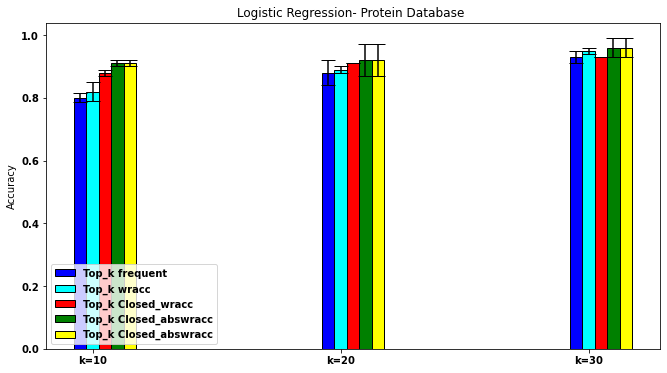

In [53]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
 
plt.figure(figsize=(11,6))
# width of the bars
barWidth = 0.05
 
# Choose the height of the blue bars
bars1 = [0.8, 0.88, 0.93]

 
# Choose the height of the error bars (bars1)
yer1 = [0.015, 0.04, 0.02]



# Choose the height of the cyan bars
bars2 = [0.82, 0.89, 0.95]
# Choose the height of the error bars (bars2)
yer2 = [0.03, 0.01, 0.01]
 

# Choose the height of the cyan bars
bars3 = [0.88, 0.91, 0.93]
# Choose the height of the error bars (bars2)
yer3 = [0.01, 0.0, 0.0]


# Choose the height of the cyan bars
bars4 = [0.91, 0.92, 0.96]
# Choose the height of the error bars (bars2)
yer4 = [0.01, 0.05, 0.03]


bars5 = [0.91, 0.92, 0.96]
# Choose the height of the error bars (bars2)
yer5 = [0.01, 0.05, 0.03]


    # The x position of bars
r1 = np.arange(len(bars1))
print(r1)
r2 = [x + barWidth for x in r1]
print(r2)
r3 = [x + 2*barWidth for x in r1]
print(r3)
r4 = [x + 3*barWidth for x in r1]
print(r4)
r5 = [x + 4*barWidth for x in r1]
print(r4)
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Top_k frequent')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='Top_k wracc')

# Create cyan bars
plt.bar(r3, bars3, width = barWidth, color = 'red', edgecolor = 'black', yerr=yer3, capsize=7, label='Top_k Closed_wracc')

# Create cyan bars
plt.bar(r4, bars4, width = barWidth, color = 'green', edgecolor = 'black', yerr=yer4, capsize=7, label='Top_k Closed_abswracc')

# Create cyan bars
plt.bar(r5, bars5, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=yer5, capsize=7, label='Top_k Closed_abswracc')

# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], ['k=10', 'k=20', 'k=30'])
plt.ylabel('Accuracy')
plt.title('Logistic Regression- Protein Database ')
plt.legend()
 
# Show graphic
plt.show()

# Importing packages

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import time

In [55]:
from topk_spade import *
from f2_spade import *

In [56]:
def imp(x):
    if(x == 1 or x == 0):
        return 0
    return -(x*np.log2(x))-((1-x)*np.log2(1-x))
    #return x*(1-x)

In [57]:
def check_subsequence(a,b):
    # This function check if b is a subsequence of a
    # a is the possible supersequence
    # b is the possible subsequence
    try:
        if len(b)<len(a):
            start=a.index(b[0])
            count=0
            for idx in range(len(a)-start):
                if count<len(b) and a[start+idx]==b[count]:
                    count+=1
            if count==len(b):
                return True
        return False
    except:
        return False

In [74]:
def Create_df(seqList,positiveTrans,negativeTrans):
    '''
    seqList=[]
    for i in selected:
        seqs=list(selected[i])
        for seq in seqs:
            seqList.append(seq)
    '''
    frame = pd.DataFrame(columns = list(seqList)+['label'])
    counter=0
    # Adding Positive Class
    for transaction in positiveTrans:
        seqObserved=[]
        for seq in seqList:
            seqObserved.append(int(check_subsequence(transaction,seq)))
        seqObserved.append(True)
        frame.loc[counter]=seqObserved
        counter+=1
    # Adding Negative Class
    for transaction in negativeTrans:
        seqObserved=[]
        for seq in seqList:
            seqObserved.append(int(check_subsequence(transaction,seq)))
        seqObserved.append(False)
        frame.loc[counter]=seqObserved
        counter+=1
    frame = frame.sample(frac=1).reset_index(drop=True)
    return frame

In [75]:
def k_select(positive_seqs,negative_seqs,k,P,N,total):
    wracc_left=(P/total)*(N/total)
    Positive_seq_Discoverd=set(positive_seqs.keys())
    Negative_seq_Discoverd=set(negative_seqs.keys())
    To_discovere=Positive_seq_Discoverd.union(Negative_seq_Discoverd)
    sequences={}
    # the following wracc_x is added to compute weighted relative accuracy (Wracc)
    for sequence in To_discovere:
        wracc_x=wracc_left*((positive_seqs.get(sequence,0)/P)-(negative_seqs.get(sequence,0)/N))
        sequences[sequence]=[positive_seqs.get(sequence,0),negative_seqs.get(sequence,0),np.round(wracc_x,5)]

    sequences=sorted(sequences.items(), key=lambda item: item[1][2],reverse=True)
    i=1
    j=0
    prev=sequences[0][1][2]
    top_k_seq=[]
    for sequence in sequences:
        if sequence[1][2]!=prev:
            i+=1
            prev=sequence[1][2]
        if i<=k:
            top_k_seq.append(sequence[0])
            j+=1
        else:
            break
    return set(top_k_seq)

In [85]:
def k_select_closed(positive_seqs,negative_seqs,k,P,N,total,score_type='wracc', printing=False):
    '''
    This function finds tok-k closed sequences with respect to a score defined by score_type ('wracc','abswracc','infogain')
    '''
    wracc_left=(P/total)*(N/total)
    Positive_seq_Discoverd=set(positive_seqs.keys())
    Negative_seq_Discoverd=set(negative_seqs.keys())
    To_discover=Positive_seq_Discoverd.union(Negative_seq_Discoverd)
    sequences={}
    
    for sequence in To_discover:
        p=positive_seqs.get(sequence,0)
        n=negative_seqs.get(sequence,0)
        if score_type.strip()=='wracc':
            score=wracc_left*((p/P)-(n/N))
        elif score_type.strip()=='abswracc':
            score=abs(wracc_left*((p/P)-(n/N)))
        elif score_type.strip()=='infogain':

            score=imp(P/total)-(((p+n)/(total))*imp(p/(p+n)))
            if (P != p or N!= n):
                #print((((P+N-p-n)/(total))*imp((P-p)/(P+N-p-n))))
                score-=(((P+N-p-n)/(total))*imp((P-p)/(P+N-p-n)))
        sequences[sequence]=[p,n,np.round(score,5),p+n]
    
    sorted_sequences=sorted(sequences.items(), key=lambda item: item[1][2],reverse=True)
    i=1
    j=0
    k_selected=[]
    prev=sorted_sequences[0][1][2]
    for sequence in sorted_sequences:
        if sequence[1][2]!=prev:
            i+=1
            prev=sequence[1][2]
        if i<=k:
            status=True
            possible_super=sequence[0]
            idx=0
            while idx<len(k_selected):
                possible_subsequence=k_selected[idx]
                if check_subsequence(possible_super,possible_subsequence):
                    if sequences[possible_super][3]==sequences[possible_subsequence][3]:

                        p=k_selected.pop(idx)
                        idx-=1
                
                if check_subsequence(possible_subsequence,possible_super):
                    if sequences[possible_super][3]==sequences[possible_subsequence][3]:
                        status=False
                idx+=1
            if status:
                k_selected.append(possible_super)
            j+=1
        else:
            break
    if printing==True:
        for sequence in k_selected:
            out='['+', '.join(list(sequence))+']'
            print(out,sequences[sequence][0],sequences[sequence][1],sequences[sequence][2])
            
    return set(k_selected)

In [86]:
def get_sequence(selected):
    seqList=[]
    for i in selected:
        seqs=list(selected[i])
        for seq in seqs:
            seqList.append(seq)
    return set(seqList)

# Run time and supervised learning Analysis

## 1- Protein Dataset

In [298]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N

KS=[5,10,20,30,40,50,60,70,80,90,100]
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
f2_spadeStart=time.perf_counter()
positive_seqs=f2_spade(ds_positive, 0.2,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
f2_spadeEnd=time.perf_counter()
f2_spadeTime=f2_spadeEnd-f2_spadeStart

f2_spadeStart=time.perf_counter()
positive_seqs_closed=f2_spade(ds_positive, 0.02,printing=False)
negative_seqs_closed=f2_spade(ds_negative, 0.05,printing=False)
f2_spadeEnd=time.perf_counter()
f2_spadeTime_Closed=f2_spadeEnd-f2_spadeStart

algorithms=['top_k_frequent','top_k_wracc','top_k_Closed_wracc','top_k_Closed_abswracc','top_k_Closed_infogain']
perfs=['runtime', 'lr_test_acc', 'lr_train_acc','dt_test_acc', 'dt_train_acc' ]
details={}
for alg in algorithms:
    details[alg]={}
    for perf in perfs:
        if perf!='lr_train_acc' and perf!='dt_train_acc':
            details[alg][perf]=[]
        else:
            details[alg][perf]=np.zeros((2,len(KS)))
        
        
counter=0
for k in KS:
    print('Current k: ',k)
    """
    Begin: top_k Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    selected=topk_spade(ds_positive, ds_negative,k,printing=False)
    selected=get_sequence(selected)
    algTime=time.perf_counter()-Start
    
    frame=Create_df(selected,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
    alg_name=algorithms[0]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
        
    #details[alg_name]['lr_train_acc'].append(np.maximum(train_diff,0))
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff
    
    """
    end: top_k Logistic Regression and Decision Tree
    """
    
    """
    Begin: top_k_wracc Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    top_k_seq_wracc=k_select(positive_seqs,negative_seqs,k,P,N,total)
    algTime=time.perf_counter()-Start + f2_spadeTime
    
    frame=Create_df(top_k_seq_wracc,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)

    alg_name=algorithms[1]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff
    
    """
    end: top_k_wracc Regression and Decision Tree
    """
    
    """
    Begin: top_k_closed_wracc Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    top_k_closed_warcc=k_select_closed(positive_seqs_closed,negative_seqs_closed,k,P,N,total,score_type='wracc')
    algTime=time.perf_counter()-Start + f2_spadeTime_Closed
    
    frame=Create_df(top_k_closed_warcc,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)

    alg_name=algorithms[2]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff

    """
    end: top_k_closed_wracc Logistic Regression and Decision Tree
    """
    
    """
    Begin: top_k_closed_abswracc Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    top_k_closed_abswarcc=k_select_closed(positive_seqs_closed,negative_seqs_closed,k,P,N,total,score_type='abswracc')
    algTime=time.perf_counter()-Start + f2_spadeTime_Closed
    
    frame=Create_df(top_k_closed_abswarcc,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)

    alg_name=algorithms[3]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff

    """
    end: top_k_closed_abswracc Logistic Regression and Decision Tree
    """
    
    """
    Begin: top_k_closed_infogain Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    top_k_closed_infogain=k_select_closed(positive_seqs_closed,negative_seqs_closed,k,P,N,total,score_type='infogain')
    algTime=time.perf_counter()-Start + f2_spadeTime_Closed
    
    frame=Create_df(top_k_closed_infogain,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)

    alg_name=algorithms[4]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff

    """
    end: top_k_closed_infogain Logistic Regression and Decision Tree
    """
    counter+=1


Current k:  5
Current k:  10
Current k:  20
Current k:  30
Current k:  40
Current k:  50
Current k:  60
Current k:  70
Current k:  80
Current k:  90
Current k:  100


### Barchart for Logistic Regression

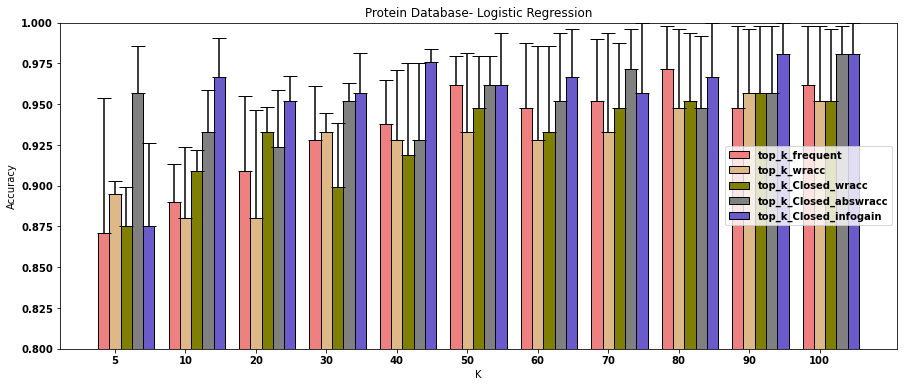

In [303]:

import numpy as np
import matplotlib.pyplot as plt

        
algorithms=['top_k_frequent','top_k_wracc','top_k_Closed_wracc','top_k_Closed_abswracc','top_k_Closed_infogain']
perfs=['runtime', 'lr_test_acc', 'lr_train_acc','dt_test_acc', 'dt_train_acc' ]

plt.figure(figsize=(15,6))
# width of the bars
barWidth = 0.16


bars_acc=[]

for alg in algorithms:
    bars_acc.append(details[alg]['lr_test_acc'])
        
bars_train=[]
    
for alg in algorithms:
    bars_train.append(details[alg]['lr_train_acc'])
        


# Choose the height of the blue bars
bars1 = bars_acc[0]

 
# Choose the height of the error bars (bars1)
yer1 = bars_train[0]



# Choose the height of the cyan bars
bars2 = bars_acc[1]
# Choose the height of the error bars (bars2)
yer2 =bars_train[1]
 

# Choose the height of the cyan bars
bars3 = bars_acc[2]
# Choose the height of the error bars (bars2)
yer3 = bars_train[2]


# Choose the height of the cyan bars
bars4 = bars_acc[3]
# Choose the height of the error bars (bars2)
yer4 = bars_train[3]


bars5 = bars_acc[4]
# Choose the height of the error bars (bars2)
yer5 =  bars_train[4]



    # The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]
r5 = [x + 4*barWidth for x in r1]


# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'lightcoral', edgecolor = 'black', yerr=yer1, capsize=7, label=algorithms[0])
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'burlywood', edgecolor = 'black', yerr=yer2, capsize=7, label=algorithms[1])

# Create cyan bars
plt.bar(r3, bars3, width = barWidth, color = 'olive', edgecolor = 'black', yerr=yer3, capsize=7, label=algorithms[2])

# Create cyan bars
plt.bar(r4, bars4, width = barWidth, color = 'gray', edgecolor = 'black', yerr=yer4, capsize=7, label=algorithms[3])

# Create cyan bars
plt.bar(r5, bars5, width = barWidth, color = 'slateblue', edgecolor = 'black', yerr=yer5, capsize=7, label=algorithms[4])



    
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], KS)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.ylim(0.8, 1)
plt.title('Protein Database- Logistic Regression')
plt.legend(loc=7)
 
# Show graphic
plt.savefig('Protein_logistic.png')
plt.show()


### Barchart for Decision Tree

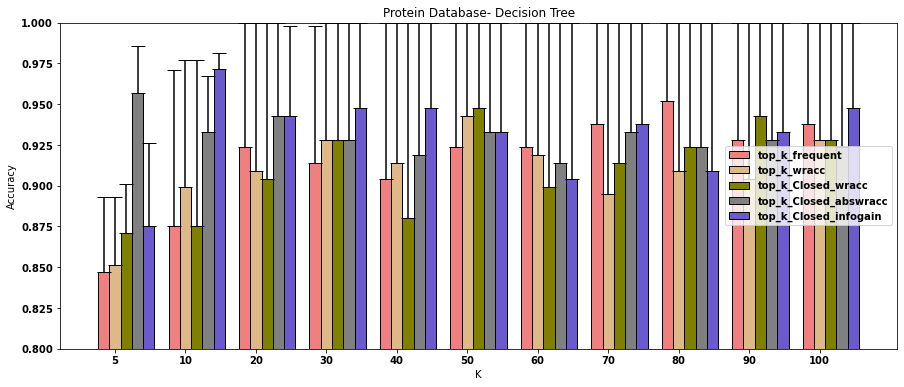

In [304]:

import numpy as np
import matplotlib.pyplot as plt

        
algorithms=['top_k_frequent','top_k_wracc','top_k_Closed_wracc','top_k_Closed_abswracc','top_k_Closed_infogain']
perfs=['runtime', 'lr_test_acc', 'lr_train_acc','dt_test_acc', 'dt_train_acc' ]

plt.figure(figsize=(15,6))
# width of the bars
barWidth = 0.16


bars_acc=[]

for alg in algorithms:
    bars_acc.append(details[alg]['dt_test_acc'])
        
bars_train=[]
    
for alg in algorithms:
    bars_train.append(details[alg]['dt_train_acc'])
        


# Choose the height of the blue bars
bars1 = bars_acc[0]

 
# Choose the height of the error bars (bars1)
yer1 = bars_train[0]



# Choose the height of the cyan bars
bars2 = bars_acc[1]
# Choose the height of the error bars (bars2)
yer2 =bars_train[1]
 

# Choose the height of the cyan bars
bars3 = bars_acc[2]
# Choose the height of the error bars (bars2)
yer3 = bars_train[2]


# Choose the height of the cyan bars
bars4 = bars_acc[3]
# Choose the height of the error bars (bars2)
yer4 = bars_train[3]


bars5 = bars_acc[4]
# Choose the height of the error bars (bars2)
yer5 =  bars_train[4]



    # The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]
r5 = [x + 4*barWidth for x in r1]


# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'lightcoral', edgecolor = 'black', yerr=yer1, capsize=7, label=algorithms[0])
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'burlywood', edgecolor = 'black', yerr=yer2, capsize=7, label=algorithms[1])

# Create cyan bars
plt.bar(r3, bars3, width = barWidth, color = 'olive', edgecolor = 'black', yerr=yer3, capsize=7, label=algorithms[2])

# Create cyan bars
plt.bar(r4, bars4, width = barWidth, color = 'gray', edgecolor = 'black', yerr=yer4, capsize=7, label=algorithms[3])

# Create cyan bars
plt.bar(r5, bars5, width = barWidth, color = 'slateblue', edgecolor = 'black', yerr=yer5, capsize=7, label=algorithms[4])



    
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], KS)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.ylim(0.8, 1)
plt.title('Protein Database- Decision Tree')
plt.legend(loc=7)
 
# Show graphic
plt.savefig('Protein_Decision Tree.png')
plt.show()


### plot for running Time

In [301]:
details

{'top_k_frequent': {'runtime': [0.01073270000051707,
   0.025015999999595806,
   0.07750099999975646,
   0.1309514999957173,
   2.0086530999979004,
   3.9824264999988372,
   4.749646099997335,
   7.344069500002661,
   25.576422199999797,
   38.7997933000006,
   44.7984185000023],
  'lr_test_acc': [0.8708133971291866,
   0.8899521531100478,
   0.9090909090909091,
   0.9282296650717703,
   0.937799043062201,
   0.9617224880382775,
   0.9473684210526315,
   0.9521531100478469,
   0.9712918660287081,
   0.9473684210526315,
   0.9617224880382775],
  'lr_train_acc': array([[-0.08274755,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ],
         [ 0.        ,  0.02362809,  0.0456416 ,  0.03267568,  0.02722153,
           0.01770138,  0.0402859 ,  0.03755882,  0.02665052,  0.05057397,
           0.0362199 ]]),
  'dt_test_acc': [0.84688995215311,
   0.8755980861244019,
   0.9234449760765551,
   

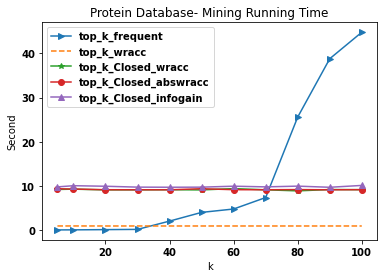

In [305]:
algorithms=['top_k_frequent','top_k_wracc','top_k_Closed_wracc','top_k_Closed_abswracc','top_k_Closed_infogain']
arrow=['->','--','-*','-o','-^']
for i in  range(len(algorithms)):
    alg=algorithms[i]
    elapsedtime= details[alg]['runtime']
    plt.plot(KS,elapsedtime,arrow[i],label=alg)
plt.title('Protein Database- Mining Running Time')
plt.xlabel('k')
plt.ylabel('Second')
plt.legend()
# Show graphic
plt.savefig('Protein_runtime.png')
plt.show()

## 1- Reuters Dataset

In [307]:
# TODO: read the dataset files and call your miner to print the top k itemsets
ds_positive=Dataset_Sequence('r-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('r-negative.txt')
N=ds_negative.trans_num() #  The number of transactions in negative class
total=P+N

KS=[5,10,20,30,40,50,60,70,80,90,100]
#KS=[5,10,20]
#print('P=',P,"N=",N,'Total=',total)
#print(ds_positive.transactions)
f2_spadeStart=time.perf_counter()
positive_seqs=f2_spade(ds_positive, 0.2,printing=False)
negative_seqs=f2_spade(ds_negative, 0.05,printing=False)
f2_spadeEnd=time.perf_counter()
f2_spadeTime=f2_spadeEnd-f2_spadeStart


algorithms=['top_k_frequent','top_k_wracc']
perfs=['runtime', 'lr_test_acc', 'lr_train_acc','dt_test_acc', 'dt_train_acc' ]
details={}
for alg in algorithms:
    details[alg]={}
    for perf in perfs:
        if perf!='lr_train_acc' and perf!='dt_train_acc':
            details[alg][perf]=[]
        else:
            details[alg][perf]=np.zeros((2,len(KS)))
        
        
counter=0
for k in KS:
    print('Current k: ',k)
    """
    Begin: top_k Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    selected=topk_spade(ds_positive, ds_negative,k,printing=False)
    selected=get_sequence(selected)
    algTime=time.perf_counter()-Start
    
    frame=Create_df(selected,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)
    alg_name=algorithms[0]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff
    
    """
    end: top_k Logistic Regression and Decision Tree
    """
    
    """
    Begin: top_k_wracc Logistic Regression and Decision Tree
    """
    Start=time.perf_counter()
    top_k_seq_wracc=k_select(positive_seqs,negative_seqs,k,P,N,total)
    algTime=time.perf_counter()-Start + f2_spadeTime
    
    frame=Create_df(top_k_seq_wracc,ds_positive.transactions,ds_negative.transactions)# creating the dataframe
    X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1], frame.iloc[:,-1], test_size=0.3, random_state=42)

    alg_name=algorithms[1]
    details[alg_name]['runtime'].append(algTime)
    
    lr = LogisticRegression(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=lr.score(X_test, y_test.astype(int))
    train_acc=lr.score(X_train, y_train.astype(int))
    details[alg_name]['lr_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['lr_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['lr_train_acc'][0,counter]=train_diff
    

    dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.astype(int))
    test_acc=dt.score(X_test, y_test.astype(int))
    train_acc=dt.score(X_train, y_train.astype(int))
    details[alg_name]['dt_test_acc'].append(test_acc)
    train_diff=train_acc-test_acc
    if train_diff>0:
        details[alg_name]['dt_train_acc'][1,counter]=train_diff
    else:
        details[alg_name]['dt_train_acc'][0,counter]=train_diff
    
    """
    end: top_k_wracc Regression and Decision Tree
    """
    counter+=1

Current k:  5
Current k:  10
Current k:  20
Current k:  30
Current k:  40
Current k:  50
Current k:  60
Current k:  70
Current k:  80
Current k:  90
Current k:  100


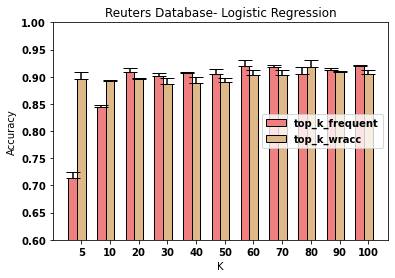

In [308]:

import numpy as np
import matplotlib.pyplot as plt

        
algorithms=['top_k_frequent','top_k_wracc']
perfs=['runtime', 'lr_test_acc', 'lr_train_acc','dt_test_acc', 'dt_train_acc' ]

#plt.figure(figsize=(15,6))
# width of the bars
barWidth = .3


bars_acc=[]

for alg in algorithms:
    bars_acc.append(details[alg]['lr_test_acc'])
        
bars_train=[]
    
for alg in algorithms:
    bars_train.append(details[alg]['lr_train_acc'])
        


# Choose the height of the blue bars
bars1 = bars_acc[0]

 
# Choose the height of the error bars (bars1)
yer1 = bars_train[0]



# Choose the height of the cyan bars
bars2 = bars_acc[1]
# Choose the height of the error bars (bars2)
yer2 =bars_train[1]
 




    # The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'lightcoral', edgecolor = 'black', yerr=yer1, capsize=7, label=algorithms[0])
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'burlywood', edgecolor = 'black', yerr=yer2, capsize=7, label=algorithms[1])




    
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], KS)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.ylim(0.6, 1)
plt.title('Reuters Database- Logistic Regression')
plt.legend(loc=7)
 
# Show graphic
plt.savefig('Reuters_logistic.png')
plt.show()


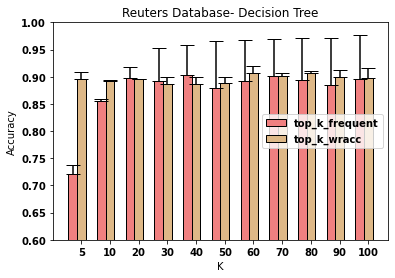

In [309]:

import numpy as np
import matplotlib.pyplot as plt

        
algorithms=['top_k_frequent','top_k_wracc']
perfs=['runtime', 'lr_test_acc', 'lr_train_acc','dt_test_acc', 'dt_train_acc' ]

#plt.figure(figsize=(15,6))
# width of the bars
barWidth = .3


bars_acc=[]

for alg in algorithms:
    bars_acc.append(details[alg]['dt_test_acc'])
        
bars_train=[]
    
for alg in algorithms:
    bars_train.append(details[alg]['dt_train_acc'])
        


# Choose the height of the blue bars
bars1 = bars_acc[0]

 
# Choose the height of the error bars (bars1)
yer1 = bars_train[0]



# Choose the height of the cyan bars
bars2 = bars_acc[1]
# Choose the height of the error bars (bars2)
yer2 =bars_train[1]
 




    # The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'lightcoral', edgecolor = 'black', yerr=yer1, capsize=7, label=algorithms[0])
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'burlywood', edgecolor = 'black', yerr=yer2, capsize=7, label=algorithms[1])




    
# general layout
plt.xticks([r + barWidth for r in range(len(bars1))], KS)
plt.ylabel('Accuracy')
plt.xlabel('K')
plt.ylim(0.6, 1)
plt.title('Reuters Database- Decision Tree')
plt.legend(loc=7)
 
# Show graphic
plt.savefig('Reuters_Decision Tree.png')
plt.show()


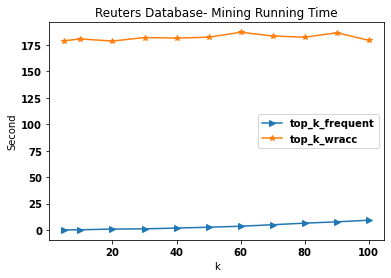

In [310]:
algorithms=['top_k_frequent','top_k_wracc']
arrow=['->','-*']
for i in  range(len(algorithms)):
    alg=algorithms[i]
    elapsedtime= details[alg]['runtime']
    plt.plot(KS,elapsedtime,arrow[i],label=alg)
plt.title('Reuters Database- Mining Running Time')
plt.xlabel('k')
plt.ylabel('Second')
plt.legend()
# Show graphic
plt.savefig('Reuters_runtime.png')
plt.show()

In [317]:
ds_positive=Dataset_Sequence('p-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('p-negative.txt')
print('p-positive',ds_positive.trans_num())
print('p-negative',ds_negative.trans_num())

p-positive 314
p-negative 381


In [316]:
ds_positive=Dataset_Sequence('r-positive.txt')
P=ds_positive.trans_num() #  The number of transactions in positive class
ds_negative=Dataset_Sequence('r-negative.txt')
print('r-positive',ds_positive.trans_num())
print('r-negative',ds_negative.trans_num())

r-positive 2838
r-negative 1594


In [315]:
print('r-positive',ds_positive.items_num())
print('r-negative',ds_negative.items_num())

r-positive 7720
r-negative 7852
